#### Stateful LangGraph + Gradio chatbot with ChatOpenAI LLM, tool integration (search & push), and persistent memory


"""
LangGraph + Gradio Chatbot

This script implements a stateful chatbot using LangGraph and Gradio with the following features:

1. LLM Integration:
   - Uses ChatOpenAI ('gpt-4o-mini') as the language model.
   - Binds tools to the LLM for dynamic tool execution during conversation.

2. Tools:
   - Google Serper API for online search queries.
   - Pushover API to send push notifications.

3. State Management:
   - Defines a TypedDict 'State' to track conversation messages.
   - Uses 'add_messages' reducer to append messages to state history.
   - Employs MemorySaver to persist the state across sessions.

4. Graph Architecture:
   - Builds a StateGraph with nodes:
       - 'chatbot': invokes the LLM and updates messages.
       - 'tools': executes bound tools when triggered.
   - Conditional edges ensure that after a tool is executed, control returns to the chatbot.
   - START → chatbot → (tools if needed) → chatbot → END loop.

5. User Interface:
   - Gradio ChatInterface wraps the chatbot function.
   - Displays a chat UI that interacts with the LangGraph message graph.

6. Execution:
   - Invoking 'chat(user_input, history)' updates the state and returns the latest LLM response.
   - Graph visualization rendered via IPython display for debugging.
"""


In [1]:
from typing import Annotated,TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_openai import ChatOpenAI
import requests
import os
import gradio as gr
from IPython.display import Image,display
from dotenv import load_dotenv

In [2]:
load_dotenv(override=True)

True

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper =GoogleSerperAPIWrapper()

from langchain.agents import Tool

tool_search =Tool(name="search",
func=serper.run,
description="search when online info is needed"
)



In [6]:
tool_search.invoke("who is current pm of india and what year he was elected?")

"Narendra Damodardas Modi (born 17 September 1950) is an Indian politician who has served as the prime minister of India since 2014. Narasimha Rao, Atal Bihari Vajpayee, Manmohan Singh, and Narendra Modi, who is the current prime minister of India, serving since 26 May 2014. He is the first ... Narendra Modi is the 14th prime minister of India. His Hindu nationalist policies and some of his economic reforms have proved controversial to many within ... Shri Narendra Modi was sworn-in as India's Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary ... PM Narendra Modi was sworn-in as the Prime Minister of India on 30th May 2019, marking the start of his second term in office. The first ever Prime Minister ... Missing: current | Show results with:current. Indian leader Narendra Modi was sworn in for 3rd term as prime minister With his power curbed, and leading a coalition government, Indian Prime ... Shri Narendra Modi was sworn-

In [4]:
pushover_user =os.getenv('PUSHOVER_USER')
pushover_api=os.getenv('PUSHOVER_API')
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text:str):
    requests.post(url=pushover_url,data={"token":pushover_api,"user":pushover_user,"message":text})
    

In [5]:
tool_push =Tool(
    name="push_notifications",
    func=push,
    description="sends push notification when hit"
)



In [9]:
tool_push.invoke("Hi checking")

In [6]:
tools=[tool_search,tool_push]


In [7]:
llm =ChatOpenAI(model='gpt-4o-mini')
llm_with_tools =llm.bind_tools(tools=tools)

Add Memory


In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()


Build State

In [8]:
class State(TypedDict):
    messages: Annotated[list,add_messages]
    

Build Graph

In [10]:
graph_builder = StateGraph(State)

In [13]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]} #LangGraph expects each node to output a dictionary of key-value pairs that match the State schema. Keys: which part of the state you’re updating. Values: what you’re adding or overwriting.
    
    #notes
    #If you only returned a string, object, or list (like just llm_with_tools.invoke(...)), the framework wouldn’t know:

    # Which key of the state it belongs to.

    # How to merge it with the rest of the graph’s state.

    # Whether to append, replace, or ignore it.

    # In your state definition:

    # messages: Annotated[list, add_messages]


    # add_messages means append to list rather than replace it.

    # So LangGraph expects each node to return a list of new messages (not a single message), so it can append them to the conversation history.

    # Hence you must wrap it like:

    # {"messages": [new_message]}
    # If you instead returned just:

    # {"messages": new_message}


    # it would fail or overwrite the list entirely, depending on the reducer.

In [14]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools=tools))

graph_builder.add_edge(START,'chatbot')
graph_builder.add_conditional_edges('chatbot',tools_condition,"tools")
graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge('chatbot',END)



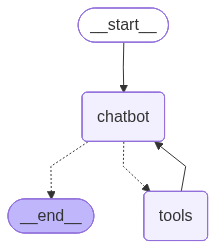

In [15]:
graph=graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
config={"configurable":{"thread_id":"1"}}

In [17]:
def chat(user_input:str,history):
    result = graph.invoke({"messages":[{"role":"user","content":user_input}]},config=config)
    
    for msg in result["messages"]:
        if msg.type =='human':
            print("human_mes:",msg.content,end="|")
        elif msg.type =='ai':
            print("ai_mes:",msg.content,end="|")
    print(result)
    return result['messages'][-1].content

gr.ChatInterface(chat,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


human_mes: what are u doing rn?|ai_mes: I'm here to assist you! How can I help you today?|{'messages': [HumanMessage(content='what are u doing rn?', additional_kwargs={}, response_metadata={}, id='37f49b0a-b6b5-4b88-96c4-9d7687df6502'), AIMessage(content="I'm here to assist you! How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 83, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CVIMxQCyPHEWFklqvrZUyBlH4qmZB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1aee6759-b925-4625-94d9-08439d612106-0', usage_metadata={'input_tokens': 83, 'output_tokens': 14, 'total_tokens': 97, 'input_token_details': 

In [18]:
graph.get_state(config)


StateSnapshot(values={'messages': [HumanMessage(content='what are u doing rn?', additional_kwargs={}, response_metadata={}, id='37f49b0a-b6b5-4b88-96c4-9d7687df6502'), AIMessage(content="I'm here to assist you! How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 83, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CVIMxQCyPHEWFklqvrZUyBlH4qmZB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1aee6759-b925-4625-94d9-08439d612106-0', usage_metadata={'input_tokens': 83, 'output_tokens': 14, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, '

In [19]:
list(graph.get_state(config)) #This gets the current memory/state of your LangGraph session what it remembers so far
# here if we recreate new memory object or recreate the graph or create new thread id from eg 1 ->2, rerun it  (eg rerunning graph ,recreating same thread with same name or simply rereun the code it will forget things)

[{'messages': [HumanMessage(content='what are u doing rn?', additional_kwargs={}, response_metadata={}, id='37f49b0a-b6b5-4b88-96c4-9d7687df6502'),
   AIMessage(content="I'm here to assist you! How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 83, 'total_tokens': 97, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CVIMxQCyPHEWFklqvrZUyBlH4qmZB', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1aee6759-b925-4625-94d9-08439d612106-0', usage_metadata={'input_tokens': 83, 'output_tokens': 14, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),

Above is just stored in ram so im going to save it in db (sqllite)

Use sqllite db for save chat history ,Langgraph checkpoints

In [9]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [10]:


db_path ="memory.db"
conn = sqlite3.connect(database=db_path,check_same_thread=False)
sql_memory =SqliteSaver(conn)


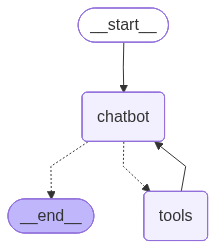

In [11]:



graph_builder =StateGraph(State)

llm_with_tools =llm.bind_tools(tools=tools)

def chatbot(state:State):
    print(state)
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node('chatbot',chatbot)
graph_builder.add_node('tools',ToolNode(tools=tools))

graph_builder.add_edge(START,'chatbot')
graph_builder.add_conditional_edges('chatbot',tools_condition,'tools')
graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge('chatbot',END)

graph =graph_builder.compile(checkpointer=sql_memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [12]:
config ={"configurable":{"thread_id":"6"}}

In [13]:
def chat(user_query:str,history):
    result =graph.invoke({"messages":[{"role":"user","content":user_query}]},config=config)
    return result['messages'][-1].content

gr.ChatInterface(chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='my name is hin', additional_kwargs={}, response_metadata={}, id='952d7853-376c-4fdd-a410-3648b19b8b10'), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='bc5b74f2-246f-441d-a810-9cbbcf63d3fb')]}


In [17]:
states=list(graph.get_state(config))
states
len(states)

8

In [18]:
states = list(graph.get_state(config))

print(f"Total checkpoints: {len(states)}\n")

for i, state in enumerate(states):
    print(f"Checkpoint {i}:")
    print(state)
    print("-" * 40)


Total checkpoints: 8

Checkpoint 0:
{'messages': [HumanMessage(content='my name is hin', additional_kwargs={}, response_metadata={}, id='952d7853-376c-4fdd-a410-3648b19b8b10'), HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='bc5b74f2-246f-441d-a810-9cbbcf63d3fb'), AIMessage(content='Hello, Hin! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 86, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CVP39SgLcKB6pVoDNXgxJheRU8HTn', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--34674992-cccf-4a36-a66d-730f569759dc-0', usage_metadata={'input_tokens': 86, 'output_tokens': 12

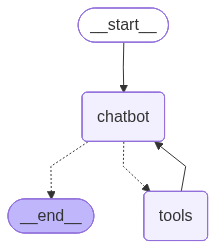

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


In [40]:
#### Stateful LangGraph + Gradio chatbot with ChatOpenAI LLM, tool integration (search & push), persistent memory, and detailed logging

from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langgraph.checkpoint.memory import MemorySaver
import requests
import os
import gradio as gr
from IPython.display import Image, display
from dotenv import load_dotenv
import logging
from copy import deepcopy

# ----------------------------
# Load environment variables
# ----------------------------
load_dotenv(override=True)
pushover_user = os.getenv('PUSHOVER_USER')
pushover_api = os.getenv('PUSHOVER_API')
pushover_url = "https://api.pushover.net/1/messages.json"

# ----------------------------
# Setup Logging
# ----------------------------
os.makedirs("logs", exist_ok=True)
logging.basicConfig(
    filename="logs/langgraph_detailed.log",
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger(__name__)

# ----------------------------
# Tools
# ----------------------------
serper = GoogleSerperAPIWrapper()

def push(text: str):
    requests.post(
        url=pushover_url,
        data={"token": pushover_api, "user": pushover_user, "message": text}
    )

def tool_with_logging(tool_name, func, *args, **kwargs):
    logger.info(f"[TOOL] {tool_name} called with args={args}, kwargs={kwargs}")
    result = func(*args, **kwargs)
    logger.info(f"[TOOL] {tool_name} output: {result}")
    return result

tool_search = Tool(
    name="search",
    func=lambda query: tool_with_logging("search", serper.run, query),
    description="search when online info is needed"
)

tool_push = Tool(
    name="push_notifications",
    func=lambda text: tool_with_logging("push_notifications", push, text),
    description="sends push notification when hit"
)

tools = [tool_search, tool_push]

# ----------------------------
# LLM and bind tools
# ----------------------------
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools=tools)

def invoke_llm_with_logging(messages):
    logger.info(f"[LLM] Invoked with messages: {messages}")
    # If your LangGraph binding exposes which tools were called, log them here
    result = llm_with_tools.invoke(messages)
    tools_called = getattr(llm_with_tools, "tools_called", None)
    logger.info(f"[LLM] Output: {result} | Tools called: {tools_called}")
    return result

# ----------------------------
# Memory / Checkpoint
# ----------------------------
memory = MemorySaver()
logger.info("[CHECKPOINT] MemorySaver initialized")

# ----------------------------
# State Definition
# ----------------------------
class State(TypedDict):
    messages: Annotated[list, add_messages]

# ----------------------------
# Build Graph
# ----------------------------
graph_builder = StateGraph(State)

def chatbot(state: State):
    prev_state = deepcopy(state)
    logger.info(f"[NODE] Chatbot called | Previous state: {prev_state}")

    llm_result = invoke_llm_with_logging(state['messages'])
    new_state = {"messages": [llm_result]}

    logger.info(f"[NODE] Chatbot finished | Updated state: {new_state}")
    return new_state

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Graph edges with conditional routing
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    "tools"
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)
logger.info("[GRAPH] Graph compiled with checkpoint")
display(Image(graph.get_graph().draw_mermaid_png()))

# ----------------------------
# Chat Interface
# ----------------------------
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    prev_state = {"messages": history}
    logger.info(f"[USER] Input: {user_input} | Previous state: {prev_state}")

    # Invoke graph
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)

    current_state = deepcopy(result)
    logger.info(f"[GRAPH] Updated state after invocation: {current_state}")

    last_response = result['messages'][-1].content
    logger.info(f"[CHAT] Returning last response: {last_response}")

    return last_response

gr.ChatInterface(chat, type='messages').launch()


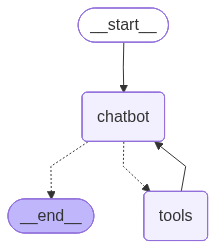

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


In [41]:
#### Stateful LangGraph + Gradio chatbot with ChatOpenAI LLM, tool integration (search & push),
# persistent memory, and detailed per-tool logging

from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langgraph.checkpoint.memory import MemorySaver
import requests
import os
import gradio as gr
from IPython.display import Image, display
from dotenv import load_dotenv
import logging
from copy import deepcopy

# ----------------------------
# Load environment variables
# ----------------------------
load_dotenv(override=True)
pushover_user = os.getenv('PUSHOVER_USER')
pushover_api = os.getenv('PUSHOVER_API')
pushover_url = "https://api.pushover.net/1/messages.json"

# ----------------------------
# Setup Logging
# ----------------------------
os.makedirs("logs", exist_ok=True)
logging.basicConfig(
    filename="logs/langgraph_detailed.log",
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger(__name__)

# ----------------------------
# Tools
# ----------------------------
serper = GoogleSerperAPIWrapper()

def push(text: str):
    requests.post(
        url=pushover_url,
        data={"token": pushover_api, "user": pushover_user, "message": text}
    )

# Global tracker for tools called per LLM invocation
tools_tracker = []

def tool_with_logging(tool_name, func, *args, **kwargs):
    logger.info(f"[TOOL] {tool_name} called with args={args}, kwargs={kwargs}")
    result = func(*args, **kwargs)
    logger.info(f"[TOOL] {tool_name} output: {result}")
    tools_tracker.append(tool_name)
    return result

tool_search = Tool(
    name="search",
    func=lambda query: tool_with_logging("search", serper.run, query),
    description="search when online info is needed"
)

tool_push = Tool(
    name="push_notifications",
    func=lambda text: tool_with_logging("push_notifications", push, text),
    description="sends push notification when hit"
)

tools = [tool_search, tool_push]

# ----------------------------
# LLM and bind tools
# ----------------------------
llm = ChatOpenAI(model='gpt-4o-mini')
llm_with_tools = llm.bind_tools(tools=tools)

def invoke_llm_with_logging(messages):
    global tools_tracker
    tools_tracker = []  # Reset tracker for each invocation
    logger.info(f"[LLM] Invoked with messages: {messages}")
    result = llm_with_tools.invoke(messages)

    # Log tools called or skipped
    if tools_tracker:
        logger.info(f"[LLM] Tools called during this invocation: {tools_tracker}")
    else:
        logger.info(f"[LLM] No tools were called during this invocation")

    return result

# ----------------------------
# Memory / Checkpoint
# ----------------------------
memory = MemorySaver()
logger.info("[CHECKPOINT] MemorySaver initialized")

# ----------------------------
# State Definition
# ----------------------------
class State(TypedDict):
    messages: Annotated[list, add_messages]

# ----------------------------
# Build Graph
# ----------------------------
graph_builder = StateGraph(State)

def chatbot(state: State):
    prev_state = deepcopy(state)
    logger.info(f"[NODE] Chatbot node called | Previous state: {prev_state}")

    llm_result = invoke_llm_with_logging(state['messages'])
    new_state = {"messages": [llm_result]}

    logger.info(f"[NODE] Chatbot node finished | Updated state: {new_state}")
    logger.info(f"[NODE] Tools invoked this turn: {tools_tracker}")

    return new_state

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Graph edges with conditional routing
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    "tools"
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile(checkpointer=memory)
logger.info("[GRAPH] Graph compiled with checkpoint")
display(Image(graph.get_graph().draw_mermaid_png()))

# ----------------------------
# Chat Interface
# ----------------------------
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    prev_state = {"messages": history}
    logger.info(f"[USER] Input: {user_input} | Previous state: {prev_state}")

    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    current_state = deepcopy(result)
    logger.info(f"[GRAPH] Updated state after invocation: {current_state}")

    last_response = result['messages'][-1].content
    logger.info(f"[CHAT] Returning last response: {last_response}")

    return last_response

gr.ChatInterface(chat, type='messages').launch()
